In [1]:
import tensorflow as tf
import numpy as np

n_inputs = 28 * 28



C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def dnn(inputs, n_hidden_layers=5, n_neurons=100,activation=tf.nn.elu, initializer=he_init, name=None):
    
    with tf.variable_scope('dnn'):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer=initializer, name=name+"hidden%d"%(layer+1))
        
        return inputs

In [4]:
X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name='X')
X1, X2 = tf.unstack(X, axis=1)
y = tf.placeholder(tf.int32, shape=[None, 1])
he_init = tf.contrib.layers.variance_scaling_initializer()

dnn1 = dnn(X1, name='DNN_A')
dnn2 = dnn(X2, name='DNN_B')

In [5]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [6]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [7]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [8]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [9]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [10]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [13]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

In [14]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]
    
        

In [15]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

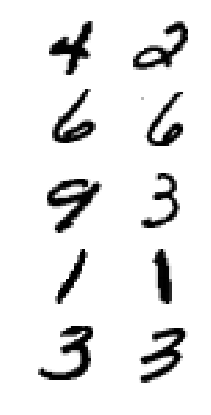

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [17]:
y_batch

array([[0],
       [1],
       [0],
       [1],
       [1]])

In [18]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [19]:
n_epochs = 100
batch_size = 500

In [20]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy", acc_test)
    save_path = saver.save(sess,'./my_digit_comparison_model.ckpt')

0 Train loss: 0.5338755
0 Test accuracy 0.7408
1 Train loss: 0.39046204
2 Train loss: 0.31425804
3 Train loss: 0.28741845
4 Train loss: 0.24531163
5 Train loss: 0.25674966
5 Test accuracy 0.9047
6 Train loss: 0.21340445
7 Train loss: 0.18449663
8 Train loss: 0.20152755
9 Train loss: 0.14857554
10 Train loss: 0.12550351
10 Test accuracy 0.94
11 Train loss: 0.1592762
12 Train loss: 0.1570555
13 Train loss: 0.13846368
14 Train loss: 0.16024707
15 Train loss: 0.11052166
15 Test accuracy 0.9541
16 Train loss: 0.102970876
17 Train loss: 0.10418608
18 Train loss: 0.119449675
19 Train loss: 0.12207922
20 Train loss: 0.10479155
20 Test accuracy 0.9565
21 Train loss: 0.091848664
22 Train loss: 0.09217306
23 Train loss: 0.049737953
24 Train loss: 0.07485326
25 Train loss: 0.0739202
25 Test accuracy 0.965
26 Train loss: 0.082870595
27 Train loss: 0.062747
28 Train loss: 0.07317226
29 Train loss: 0.08445044
30 Train loss: 0.090127766
30 Test accuracy 0.9639
31 Train loss: 0.04166068
32 Train loss: 

In [21]:
from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%H%S')
root_logdir = 'tf_logs'
logdir = "{}/run-{}/".format(root_logdir, "DNN")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [27]:
tf.get_default_graph().get_tensor_by_name('dnn/DNN_Ahidden5/Elu:0')

<tf.Tensor 'dnn/DNN_Ahidden5/Elu:0' shape=(?, 100) dtype=float32>